# Problem
In this project we are going to use machine learning model classify waterpoints so to help in identifying water resources for various communities with little resources as:

**functional** - the waterpoint is operational and there are no repairs needed 

**repair** - the waterpoint is operational, but needs repairs 

**non-functional** - the waterpoint is not operational

Techniques employed include Classification, random forest, PCA

**Sections**

1. Experiment Objective
2. Data Collection
3. Data Preprocessing
4. Model Comparison
5. Experiment Summary

# Data Collections

The datasets is divided into train and test sets with 39 features each as described [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list)

In [1]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys

*`Lets create helper functions`*

In [2]:
def label_map(y):
    """
    Maps string labels to their respective integer representatives
    """
    if y=="functional":
        return 2
    elif y=="functional needs repair":
        return 1
    else:
        return 0

In [3]:
#Load the data
# Load the data
train = pd.read_csv('training.csv', index_col='id')
labels = pd.read_csv('training_labels.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
train.head()


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [5]:
print("Train Labels:",len(labels))
print("Train set rows, columns:",train.shape)
print("Test set rows, columns:", test.shape)

Train Labels: 59400
Train set rows, columns: (59400, 39)
Test set rows, columns: (14850, 39)


In [6]:
#Merge train and test
merged = pd.merge(train, labels, on="id", how="inner", indicator=True)

# Part 3: Data Preprocessing

Data Exploration with seaborn

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


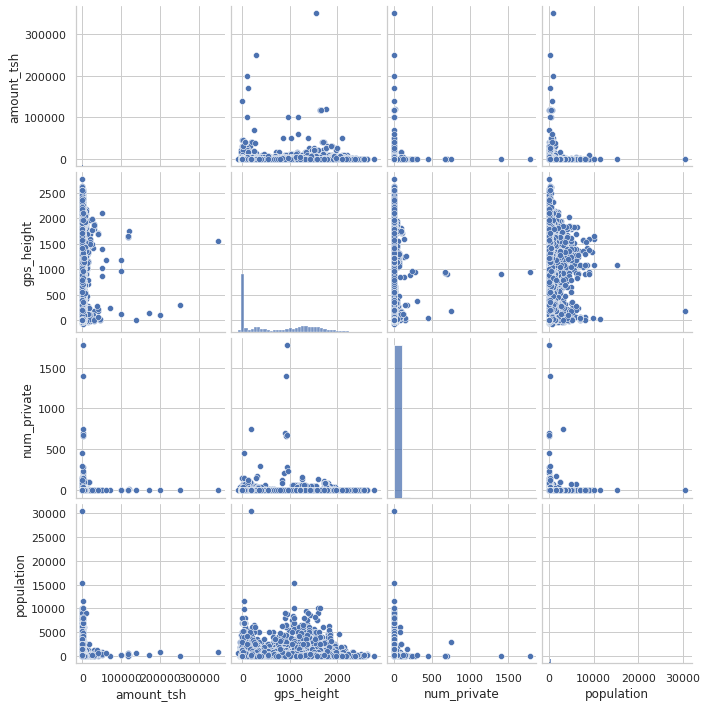

In [ ]:
# Pair plots
sns.set(style='whitegrid',context='notebook')
cols=['amount_tsh','gps_height','num_private','population','status_group']
sns.pairplot(merged[cols],size=2.5)
plt.show()

The variables plotted:

amount_tsh: total static (amount allocated to waterpoint)
gps_height: altitude 
num_private: (not explained)
population: number of people around the waterpoint
It can be said that water pumps allocated high static head tend to be functional (label 2). (It is also important to look into whether the really high amount values are realistic.)

# Funders
It is evident that waterpoints heavily relies on donors. There are 1898 different donors (funders) in the dataset with the column having a lot of missing values. Furthermore, a number of funders have too few observations i.e. occurs only once hence have less impact to the model

In [7]:
len(train.funder.value_counts(dropna=False))


1898

In [8]:
train.funder.value_counts(dropna=False)

Government Of Tanzania    9084
NaN                       3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1898, dtype: int64

To the 3635 NaNs we have 777 0s. Lets assume the zeros are missing values too, therefore totalling to 4412 missing values.

**Other issues with the data:**

* installer: contains NaNs, zeros, and a lot of low frequency entries
* scheme_name: contains NaNs and a lot of low frequency entries
* scheme_management: contains NaNs
* population: contains zeros and a lot of low frequency entries
* construction_year: contains zeros
* permit: contains NaNs
* public_meeting: contains NaNs

**How to deal with the Missing Values**

1. Drop the datapoints - Not an option since this contains a big chunk of the data
2. impute with mean or median or mode - Not an option because it will highly distort the dataset.
3. Use machine learning model to predict - This will depend on if the data is correlated
4. Create new features e.g. "No installer"

* For categorical variables, we use option 4.
* For population, we leave the 0s, for the baseline model, but later on we may try to predict these using e.g clustering or knn.
* For construction_year, we add a ‘missing_construction_year’ feature, and also run the model with and without imputation 



**Note on missing values:**

We can easily imagine that some of the NaNs might not be missing at random (for instance, year information is missing more from older waterpoints).

In [9]:
# Converting the 0s in 'funder','installer', and 'population' to NaNs. 
merged_clean = merged.replace({'funder':0, 'installer':0, 'population':0}, np.nan)
merged_clean = merged.replace({'funder':'0', 'installer':'0'}, np.nan)

In [10]:
merged_clean['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Lottery                      1
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Samlo                        1
Name: funder, Length: 1896, dtype: int64

# Working on low/many frequency entries

In this scenario, we will use 20 entries as our low frequency threshold and set to others. This number is arbotrary due to time we wouldnt test other thresholds or bin.

In [11]:
series = pd.value_counts(merged_clean['funder'])
mask = series.lt(20)
print(mask)

Government Of Tanzania    False
Danida                    False
Hesawa                    False
Rwssp                     False
World Bank                False
                          ...  
Lottery                    True
Rarymond Ekura             True
Justine Marwa              True
Municipal Council          True
Samlo                      True
Name: funder, Length: 1896, dtype: bool


In [12]:
def condense_category(col, min_freq=20, new_name='other'):
    series = pd.value_counts(col)
    mask = series.lt(min_freq)
    return pd.Series(np.where(col.isin(series[mask].index), new_name, col))


In [13]:
merged_sel= merged_clean[['funder', 'installer', 'scheme_name']]

In [14]:
merdeg_sel = merged_sel.apply(condense_category, axis=0)

In [15]:
merged_sel['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Lottery                      1
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Samlo                        1
Name: funder, Length: 1896, dtype: int64

### Construction Year
In the construction_year column we replace NaNs with 0s

In [16]:
merged_clean = merged.replace({'construction_year':0}, np.nan)
merged_clean = merged.replace({'construction_year':'0'}, np.nan)

Note that the above changed construction year column to floats

Add a feature for the NaNs in construction_year column

In [17]:
def isNan(num):
    """
    Function to test for Nan. Returns True for NaNs, False otherwise.
    """
    return num != num
    
merged_clean['missing_construction_year'] = merged_clean['construction_year'].apply(lambda x: isNan(x))

In [18]:
scale = merged[['gps_height', 'num_private', 'population', 'construction_year']]

In [19]:
scale.columns

Index(['gps_height', 'num_private', 'population', 'construction_year'], dtype='object')

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

cols_to_scale = ['gps_height', 'num_private', 'population', 'construction_year']
ct = ColumnTransformer([('column_scaler', StandardScaler(), cols_to_scale)], remainder='drop')

In [21]:
scaled_values = ct.fit_transform(scale)

In [22]:
scaled_df = pd.DataFrame(scaled_values, index=scale.index, columns=scale.columns)

# Convert categorical columns to dummy

In [23]:
merged_clean1 = merged_clean.drop(['funder', 'installer', 'scheme_name', 'date_recorded', 'status_group'], axis=1)
merged_clean_final = pd.merge(merged_clean1, merged_sel, on="id", how="inner")

In [24]:
merged_clean_dum = pd.get_dummies(merged_sel, dummy_na=True)
merged_clean_dum.shape

(59400, 6739)

In [25]:
merged_final = pd.merge(merged_clean_dum, labels, on='id', how='inner')
merged_final.shape

(59400, 6740)

In [26]:
merged_final = pd.merge(merged_final, scaled_df, on='id', how='inner')

In [ ]:
merged_clean1 = merged_clean.drop(['funder', 'installer', 'scheme_name'], axis=1)
merged_clean_dum_final = pd.merge(merged_clean1, merged_clean_dum, on="id", how="inner")
merged_clean_dum_final.shape

(59400, 6778)

In [ ]:
merged_clean_dum_final.dtypes

amount_tsh                                 float64
date_recorded                               object
gps_height                                   int64
longitude                                  float64
latitude                                   float64
                                            ...   
scheme_name_water supply at Kalebejo         uint8
scheme_name_water supply at Nyakasungwa      uint8
scheme_name_water supply in Mwanza           uint8
scheme_name_water supply in katungulu        uint8
scheme_name_nan                              uint8
Length: 6778, dtype: object

# Part 4: Model Comparison

 will try 2 models: (1) on using one-hot encoded data, with and without dimensionality reduction, and (2) on the original data without one-hot encoding

In [27]:
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler  #, Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [28]:
data = merged_final

In [29]:
data.isnull().sum()

funder_A/co Germany                   0
funder_Aar                            0
funder_Abas Ka                        0
funder_Abasia                         0
funder_Abc-ihushi Development Cent    0
                                     ..
status_group                          0
gps_height                            0
num_private                           0
population                            0
construction_year                     0
Length: 6744, dtype: int64

In [30]:
# dropping the labels
train_r = data.drop('status_group',axis=1)

# Getting labels
labels = data.status_group

In [47]:
X = train_r
y = labels.tolist() 

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

# Logistic Regression

In [32]:
RANDOM_SEED = 8
logreg = LogisticRegression(solver='saga', 
                            random_state=RANDOM_SEED, 
                            multi_class='ovr',
                            max_iter=200,
                           n_jobs=-1)

Fit the Model

In [33]:
model_log = logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Get Model Predictions

In [34]:
y_hat_train = model_log.predict(X_train)

In [35]:
y_hat_test = model_log.predict(X_test)

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [44]:
y_train = le.fit_transform(y_train)

In [45]:
y_test = le.transform(y_test)

In [48]:
print(classification_report(y_train, y_hat_train, target_names=le.classes_))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

             functional       0.63      0.85      0.72     22647
functional needs repair       0.00      0.00      0.00      2984
         non functional       0.62      0.43      0.51     15949

               accuracy                           0.63     41580
              macro avg       0.42      0.43      0.41     41580
           weighted avg       0.58      0.63      0.59     41580



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print(classification_report(y_test, y_hat_test, target_names=le.classes_))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

             functional       0.62      0.85      0.72      9612
functional needs repair       0.00      0.00      0.00      1333
         non functional       0.62      0.43      0.51      6875

               accuracy                           0.62     17820
              macro avg       0.41      0.43      0.41     17820
           weighted avg       0.58      0.62      0.58     17820



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest

In [50]:
clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

In [52]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=8)

Get Model predictions

In [53]:
rf_y_hat_train = clf.predict(X_train)

In [54]:
rf_y_hat_test = clf.predict(X_test)

Classification reports

In [56]:
print(classification_report(y_train, rf_y_hat_train, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.88      0.95      0.91     22647
functional needs repair       0.94      0.65      0.77      2984
         non functional       0.90      0.86      0.88     15949

               accuracy                           0.89     41580
              macro avg       0.91      0.82      0.86     41580
           weighted avg       0.90      0.89      0.89     41580



In [57]:
print(classification_report(y_test, rf_y_hat_test, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.72      0.81      0.76      9612
functional needs repair       0.42      0.19      0.26      1333
         non functional       0.70      0.64      0.67      6875

               accuracy                           0.70     17820
              macro avg       0.61      0.55      0.56     17820
           weighted avg       0.69      0.70      0.69     17820



**Summary of Results**

Compared to the logistic regression the results are positive.

* Negative
** The model seems overfitted with Training accuracy at 0.89 and Test accuracy at 0.71
* Positive
** Accuracy increased to 0.71 from 0.62, better than previous models.
*Recall increased for all classes

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn import decomposition

imputer = SimpleImputer(strategy='median')
pca = decomposition.PCA()
rf = RandomForestClassifier(class_weight='balanced', 
                            n_jobs=-1, 
                            n_estimators=300)

steps = [('imputer', imputer),
        ('pca', pca),
        ('random_forest', rf)]

pipeline = Pipeline(steps)
parameters = dict(
                pca__n_components=[40, 100, 300], 
                random_forest__max_features=['auto', 'log2']
                )

gs = GridSearchCV(pipeline, param_grid=parameters)
gs.fit(X_train, y_train)

KeyboardInterrupt: ignored